# Import libraries

کتابخانه های مورد نیاز پایتون را در اینجا وارد می کنیم

In [167]:
import pandas as pd
from pandas import DataFrame, Series
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timedelta,date
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from time import time
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Methods

این متود برای تبدیل داده به فرمت تاریخ است

In [168]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d %H:%M:%S')

این متود برای تست adf روی سری استفاده می شود

In [169]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

این متد برای نمایش نمودار سری زمانی استفاده می شود

In [170]:
def plot_series(series):
    plt.figure(figsize=(16,6))
    plt.plot(series, color='red')
    plt.ylabel('Search Frequency for "Distance"', fontsize=16)
    plt.xticks(rotation=90)
    for day in range(19,32):
        for hour in range(0,24):
            if hour % 6 == 0:
                plt.axvline(pd.to_datetime('2022-03-'+str(day)+' '+str(hour)+':00:00'), linestyle='--', color='k', alpha=0.5)
            

# Read data

در این سلول بعد از خواندن داده ها داده های تکراری را نمایش میدهیم

In [171]:
df = pd.read_csv('ARIMA-dataset.csv', parse_dates=[0], index_col=0, date_parser=parser)

series = df[df.index.duplicated()]

series
#df

,lat,lon,dev_acc_d
time,,,
2022-03-30 10:15:42,29.761868,57.585133,2521.89640
2022-03-30 22:15:00,34.643421,50.939423,3278.04441
2022-03-30 22:15:05,34.644884,50.938689,3278.22048
2022-03-30 22:15:10,34.646386,50.937880,3278.40324
2022-03-30 22:15:15,34.647850,50.937024,3278.58391
2022-03-30 22:15:20,34.649252,50.936171,3278.75835
2022-03-30 22:15:25,34.650621,50.935270,3278.93153


# Normalize data

در این سلول داده های تکراری را حذف می کنیم و سپس داده ها را نمایش می دهیم

In [172]:
df.drop_duplicates(inplace = True)

df

,lat,lon,dev_acc_d
time,,,
2022-03-19 15:12:54,35.724380,51.386521,0.00000
2022-03-19 15:12:59,35.723492,51.385984,0.00000
2022-03-19 15:13:04,35.723234,51.386712,0.07172
2022-03-19 15:13:09,35.723138,51.387657,0.15773
2022-03-19 15:13:14,35.723082,51.388778,0.25916
...,...,...,...
2022-03-31 01:05:51,35.721923,51.421946,3428.64584
2022-03-31 01:05:56,35.721922,51.421939,3428.64647
2022-03-31 01:06:01,35.721922,51.421938,3428.64651


در این قسمت داده های Nan را حذف کرده و سری زمانی شامل time  و dev_acc_d  را ساخته و چون داده هاتجمعی است از متد .diff()برای حذف فراوانی تجمعی استفاده کرده . داده های Nan بوجود آمده را با متد .dropna() حذف میکنیم و مجدد داده های نمایش می دهیم

In [173]:
df = df.replace(to_replace='NaN', value=np.nan).dropna()
df_dev_acc_d_series= df.dev_acc_d
df_dev_acc_d_series = df_dev_acc_d_series.diff().dropna()
df_dev_acc_d_series

time
2022-03-19 15:12:59    0.00000
2022-03-19 15:13:04    0.07172
2022-03-19 15:13:09    0.08601
2022-03-19 15:13:14    0.10143
2022-03-19 15:13:19    0.09955
                        ...   
2022-03-31 01:05:51    0.00914
2022-03-31 01:05:56    0.00063
2022-03-31 01:06:01    0.00004
2022-03-31 01:06:06    0.00920
2022-03-31 01:06:11    0.00161
Name: dev_acc_d, Length: 30750, dtype: float64

داده ها را بروش z-score نرمال می کنیم 

In [174]:
avg, dev = df_dev_acc_d_series.mean(), df_dev_acc_d_series.std()

df_dev_acc_d_series = (df_dev_acc_d_series - avg) / dev
df_dev_acc_d_series

time
2022-03-19 15:12:59   -0.827659
2022-03-19 15:13:04   -0.295290
2022-03-19 15:13:09   -0.189217
2022-03-19 15:13:14   -0.074756
2022-03-19 15:13:19   -0.088711
                         ...   
2022-03-31 01:05:51   -0.759814
2022-03-31 01:05:56   -0.822983
2022-03-31 01:06:01   -0.827362
2022-03-31 01:06:06   -0.759368
2022-03-31 01:06:11   -0.815708
Name: dev_acc_d, Length: 30750, dtype: float64

# Display and analysis data

در این قسمت مسافت طی شده طی هر ساعت را با جمع داده ها در ساعت مورد نظر  حساب می کنیم و داده های از دست رفته را با تابع .mean()  محاسبه کرده و به series خود اضافه میکنیم سپس داده ها را نمایش می دیم

In [175]:
df_dev_acc_d_series_hour=df_dev_acc_d_series.groupby(df_dev_acc_d_series.index.strftime('%Y-%m-%d %H')).sum()
df_dev_acc_d_series_hour.index = pd.to_datetime(df_dev_acc_d_series_hour.index)
df_dev_acc_d_series_hour = df_dev_acc_d_series_hour.resample('1H').mean()
df_dev_acc_d_series_hour=df_dev_acc_d_series_hour.interpolate()
df_dev_acc_d_series_hour = df_dev_acc_d_series_hour.asfreq(pd.infer_freq(df_dev_acc_d_series_hour.index))
df_dev_acc_d_series_hour

time
2022-03-19 15:00:00    -96.539729
2022-03-19 16:00:00   -195.318142
2022-03-19 17:00:00    -71.590741
2022-03-19 18:00:00   -152.494091
2022-03-19 19:00:00   -257.977372
                          ...    
2022-03-30 21:00:00    304.295059
2022-03-30 22:00:00    206.914828
2022-03-30 23:00:00    101.831929
2022-03-31 00:00:00   -160.721811
2022-03-31 01:00:00    -17.734918
Freq: H, Name: dev_acc_d, Length: 275, dtype: float64

در این قسمت داده های قسمت قبل را در نمودار نمایش داده ایم

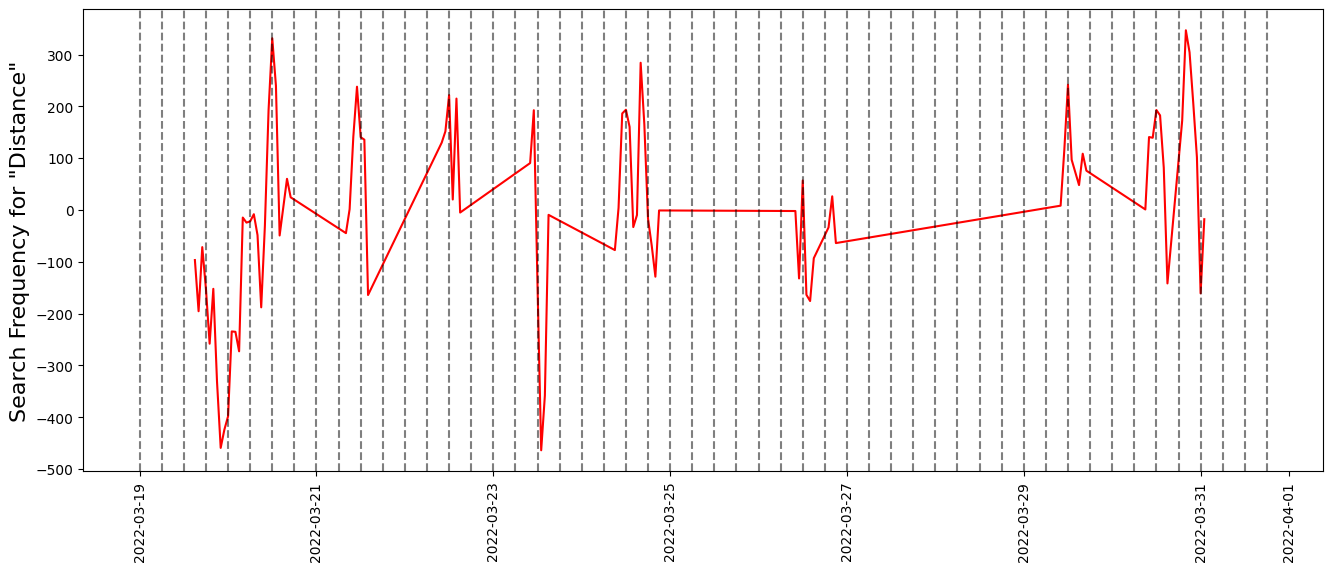

In [176]:
plot_series(df_dev_acc_d_series_hour)

حال با استفاده از تابع perform_adf_test  داده ها را تست adf می کنیم که خروجی با ما نشان می دهد p-value کم تر از 0.05  می باشد پس داده ها نیازی به stationary  شدن ندارند

In [177]:
perform_adf_test(df_dev_acc_d_series_hour)

ADF Statistic: -7.136601
p-value: 0.000000


# ARIMA model

دراین قسمت داده های تمرین(train) و داده های ازمون(test) را تعیین می کنیم که داده های تمرینی از روز 19 ام تا 29 ام تعیین شده و داده های آزمون از روز 29 تا 31 ام تعیین شده اند

In [178]:
train_end = datetime(2022,3,28,23,0,0).strftime('%Y-%m-%d %H')
test_end = datetime(2022,3,31,0,0,0).strftime('%Y-%m-%d %H')
train_end_plus = datetime(2022,3,29,0,0,0).strftime('%Y-%m-%d %H')

train_data = df_dev_acc_d_series_hour[:train_end]
test_data = df_dev_acc_d_series_hour[train_end_plus:test_end]
print(train_data)
print(test_data)

time
2022-03-19 15:00:00    -96.539729
2022-03-19 16:00:00   -195.318142
2022-03-19 17:00:00    -71.590741
2022-03-19 18:00:00   -152.494091
2022-03-19 19:00:00   -257.977372
                          ...    
2022-03-28 19:00:00     -9.368151
2022-03-28 20:00:00     -8.184715
2022-03-28 21:00:00     -7.001279
2022-03-28 22:00:00     -5.817843
2022-03-28 23:00:00     -4.634407
Freq: H, Name: dev_acc_d, Length: 225, dtype: float64
time
2022-03-29 00:00:00     -3.450971
2022-03-29 01:00:00     -2.267535
2022-03-29 02:00:00     -1.084099
2022-03-29 03:00:00      0.099337
2022-03-29 04:00:00      1.282773
2022-03-29 05:00:00      2.466209
2022-03-29 06:00:00      3.649645
2022-03-29 07:00:00      4.833081
2022-03-29 08:00:00      6.016517
2022-03-29 09:00:00      7.199953
2022-03-29 10:00:00      8.383390
2022-03-29 11:00:00    115.404249
2022-03-29 12:00:00    241.714684
2022-03-29 13:00:00     96.897916
2022-03-29 14:00:00     72.506731
2022-03-29 15:00:00     48.115547
2022-03-29 16:00:0

با توجه به شکل نمودار داده ها تقریبا به صورت خطی است که هر 6 ساعت دارای شوک و خطاست و چون نمی خواهیم diff  مقدار d  هم برابر 0 می گذاریم (trend نداریم)

In [179]:
model = ARIMA(train_data, order=(1,0,6))

اینجا مدل را فیت کرده و زمان فیت شدن را محاسبه می کنیم

In [180]:
start = time()
model_fit = model.fit()
end = time()
print('Model fitting time is: ', end-start)

Model fitting time is:  1.489973783493042


سپس خلاصه اطلاعات بدست آمده را نمایش می دهیم که نشان می دهد ar.L1  عدد کوچکی است پس باید p را تغییر دهیم و داده های ma.L1 , ma.L2  , ma.L3  بنظر اعداد خوبی هستند و ma.L4 , ma.L5 تاثیر خاصی ندارند پس بهتر است q را 3 بگذاریم

In [181]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              dev_acc_d   No. Observations:                  225
Model:                 ARIMA(1, 0, 6)   Log Likelihood               -1279.659
Date:                Thu, 10 Nov 2022   AIC                           2577.319
Time:                        15:28:45   BIC                           2608.064
Sample:                    03-19-2022   HQIC                          2589.727
                         - 03-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -20.4192     15.990     -1.277      0.202     -51.759      10.920
ar.L1         -0.2330      0.426     -0.547      0.584      -1.068       0.602
ma.L1          1.0626      0.421      2.522      0.0

حال مدل فیت شده را زمانی برابر زمان آزمون می دهیم و پیشبینی مدل را از داده آزمون کم کرده و باقی مانده که خطا است را بدست می آوریم

In [182]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions
# residuals = test_data.subtract(predictions, fill_value=0)
print(predictions)
print(test_data)
print(residuals)

2022-03-29 00:00:00    -9.624153
2022-03-29 01:00:00   -13.946449
2022-03-29 02:00:00   -16.449533
2022-03-29 03:00:00   -17.635131
2022-03-29 04:00:00   -18.357206
2022-03-29 05:00:00   -19.696781
2022-03-29 06:00:00   -20.587483
2022-03-29 07:00:00   -20.379935
2022-03-29 08:00:00   -20.428297
2022-03-29 09:00:00   -20.417028
2022-03-29 10:00:00   -20.419654
2022-03-29 11:00:00   -20.419042
2022-03-29 12:00:00   -20.419185
2022-03-29 13:00:00   -20.419152
2022-03-29 14:00:00   -20.419159
2022-03-29 15:00:00   -20.419157
2022-03-29 16:00:00   -20.419158
2022-03-29 17:00:00   -20.419158
2022-03-29 18:00:00   -20.419158
2022-03-29 19:00:00   -20.419158
2022-03-29 20:00:00   -20.419158
2022-03-29 21:00:00   -20.419158
2022-03-29 22:00:00   -20.419158
2022-03-29 23:00:00   -20.419158
2022-03-30 00:00:00   -20.419158
2022-03-30 01:00:00   -20.419158
2022-03-30 02:00:00   -20.419158
2022-03-30 03:00:00   -20.419158
2022-03-30 04:00:00   -20.419158
2022-03-30 05:00:00   -20.419158
2022-03-30

حال خطا را در نمودار نمایش می دهیم

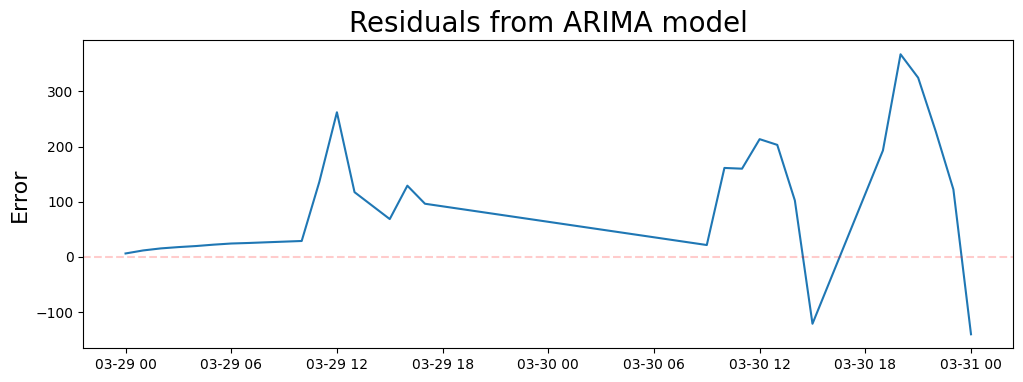

In [183]:
plt.figure(figsize=(12,4))
plt.plot(residuals)
plt.title('Residuals from ARIMA model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle ='--', alpha =0.2)

در این نمودار هم داده تست را با داده پیشبینی شده توسط مدل آریما نمایش می دهیم

Text(0, 0.5, 'distance')

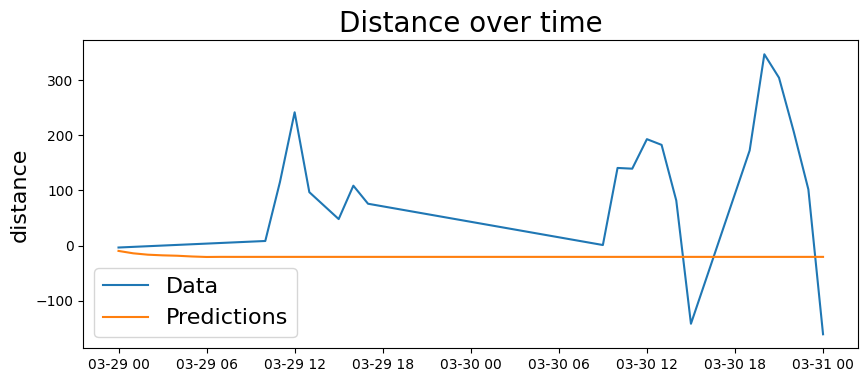

In [184]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data','Predictions'), fontsize=16)

plt.title('Distance over time', fontsize=20)
plt.ylabel('distance', fontsize=16)



حال نمودار acf با lag  24 را نمایش می دهیم که به طور تقریبی به ما می گوید ma را برابر 5 قرار دهیم با توجه به بیرون زدن میله ها از بخش رنگی

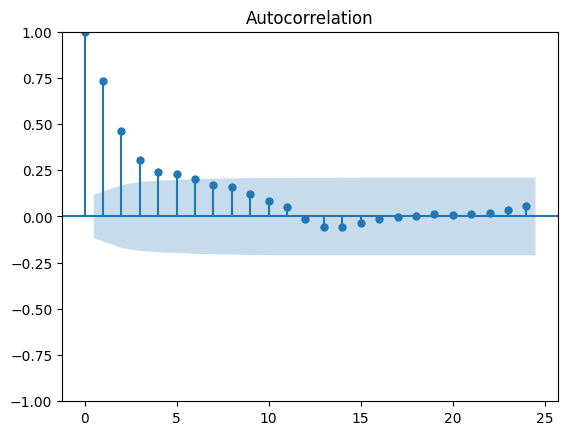

In [185]:
acf_plot = plot_acf(df_dev_acc_d_series_hour, lags=24)


حال نمودار pacf با lag  24 را نمایش می دهیم که به طور تقریبی به ما می گوید ar را برابر 2 قرار دهیم با توجه به بیرون زدن میله ها از بخش رنگی

/home/y/Desktop/iust/DataMining/exr_01/venv/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


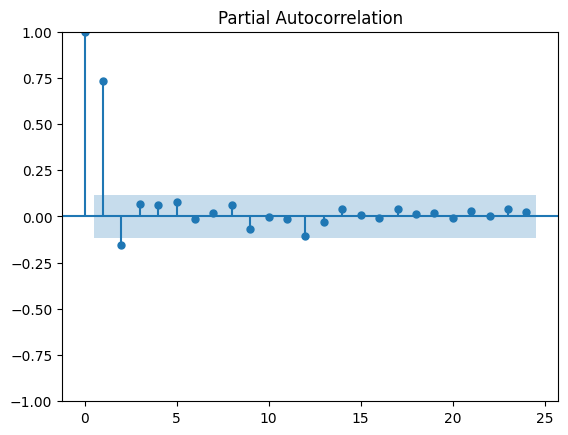

In [186]:
pacf_plot = plot_pacf(df_dev_acc_d_series_hour, lags=24)


با توجه به نمودار های pacf و acf در ARIMA مقدار p را 2  و مقدار q را 5 می گذاریم.

In [187]:
model = ARIMA(train_data, order=(2,0,5))

اینجا مدل را فیت کرده و زمان فیت شدن را محاسبه می کنیم

In [188]:
start = time()
model_fit = model.fit()
end = time()
print('Model fitting time is: ', end-start)

Model fitting time is:  1.631378173828125


/home/y/Desktop/iust/DataMining/exr_01/venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


در اینجا خلاصه مدل و ضرایب ar , ma  نوشته شده

In [189]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              dev_acc_d   No. Observations:                  225
Model:                 ARIMA(2, 0, 5)   Log Likelihood               -1280.054
Date:                Thu, 10 Nov 2022   AIC                           2578.107
Time:                        15:28:50   BIC                           2608.852
Sample:                    03-19-2022   HQIC                          2590.516
                         - 03-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -20.3413     18.283     -1.113      0.266     -56.175      15.492
ar.L1          1.6044      0.252      6.373      0.000       1.111       2.098
ar.L2         -0.7129      0.210     -3.399      0.0

حال مدل فیت شده را زمانی برابر زمان آزمون می دهیم و پیشبینی مدل را از داده آزمون کم کرده و باقی مانده که خطا است را بدست می آوریم

In [190]:
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions
# residuals = test_data.subtract(predictions, fill_value=0)
print(predictions)
print(test_data)
print(residuals)

2022-03-29 00:00:00    -8.914248
2022-03-29 01:00:00   -12.454737
2022-03-29 02:00:00   -14.431767
2022-03-29 03:00:00   -15.500034
2022-03-29 04:00:00   -16.212611
2022-03-29 05:00:00   -17.168761
2022-03-29 06:00:00   -18.194777
2022-03-29 07:00:00   -19.159232
2022-03-29 08:00:00   -19.975115
2022-03-29 09:00:00   -20.596518
2022-03-29 10:00:00   -21.011825
2022-03-29 11:00:00   -21.235123
2022-03-29 12:00:00   -21.297296
2022-03-29 13:00:00   -21.237853
2022-03-29 14:00:00   -21.098160
2022-03-29 15:00:00   -20.916417
2022-03-29 16:00:00   -20.724424
2022-03-29 17:00:00   -20.545963
2022-03-29 18:00:00   -20.396519
2022-03-29 19:00:00   -20.283985
2022-03-29 20:00:00   -20.209978
2022-03-29 21:00:00   -20.171470
2022-03-29 22:00:00   -20.162452
2022-03-29 23:00:00   -20.175435
2022-03-30 00:00:00   -20.202694
2022-03-30 01:00:00   -20.237172
2022-03-30 02:00:00   -20.273054
2022-03-30 03:00:00   -20.306042
2022-03-30 04:00:00   -20.333387
2022-03-30 05:00:00   -20.353740
2022-03-30

حال خطا را در نمودار نمایش می دهیم

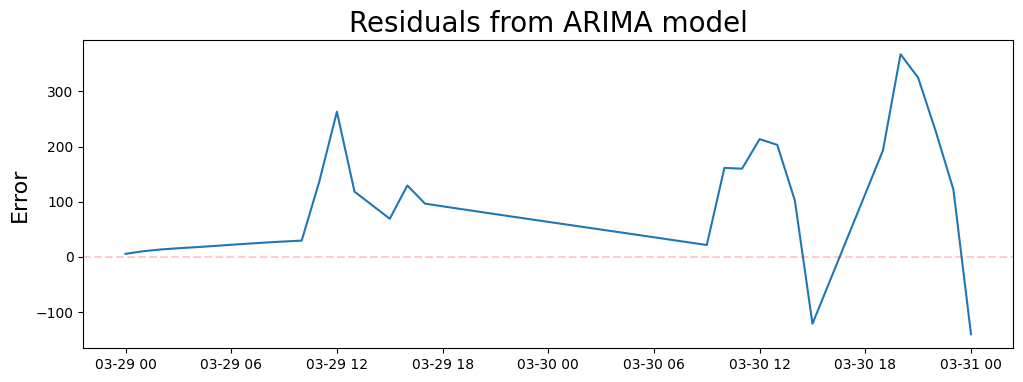

In [191]:
plt.figure(figsize=(12,4))
plt.plot(residuals)
plt.title('Residuals from ARIMA model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle ='--', alpha =0.2)

در این نمودار هم داده تست را با داده پیشبینی شده توسط مدل آریما نمایش می دهیم

Text(0, 0.5, 'distance')

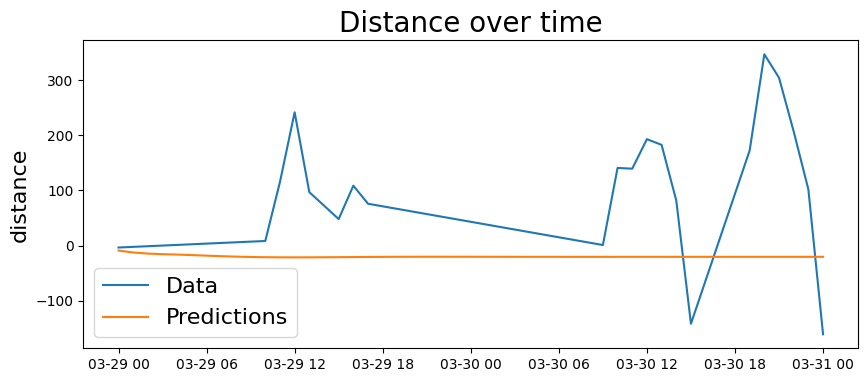

In [192]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data','Predictions'), fontsize=16)

plt.title('Distance over time', fontsize=20)
plt.ylabel('distance', fontsize=16)


در آخر هم داده ها بروش rolling پیشبینی شده اند که چندین بار داده های ازمون با داده های تمرینی فیت میشوند و در آخر داده ها به صورت پایین پیشبینی می شوند .

In [193]:
predictions_rolling = pd.Series()
for end_date in test_data.index:
    train_data = df_dev_acc_d_series_hour[:end_date]
    model = ARIMA(train_data, order=(2,0,5))
    model_fit = model.fit()
    pred = model_fit.predict(end_date)
    predictions_rolling.loc[end_date]=pred.loc[end_date]

residuals_rolling = test_data - predictions_rolling

/tmp/ipykernel_6065/3484633580.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions_rolling = pd.Series()
/home/y/Desktop/iust/DataMining/exr_01/venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/y/Desktop/iust/DataMining/exr_01/venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/y/Desktop/iust/DataMining/exr_01/venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/

/home/y/Desktop/iust/DataMining/exr_01/venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/y/Desktop/iust/DataMining/exr_01/venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/y/Desktop/iust/DataMining/exr_01/venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/y/Desktop/iust/DataMining/exr_01/venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

Text(0, 0.5, 'Distance')

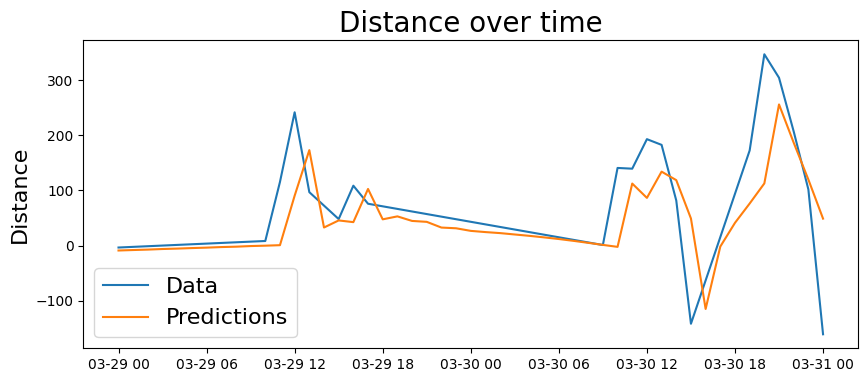

In [194]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions_rolling)

plt.legend(('Data','Predictions'), fontsize=16)

plt.title('Distance over time', fontsize=20)
plt.ylabel('Distance', fontsize=16)